# Google Analytics Capstone Project

* I decided to use multi-labeled single classsification to classify the different type of visitors in the website. This could help the digital marketing team to create their marketing efforts depending on the type of visitors. <br>
* I will use **clustering** for the first part to label the and classify the user segments. Then I will use **supervised learning** algorithms to hceck if I can predict beforehand if what segment will that user belong <br>
* This strategy is aligned with the concept of Segmentation, Targeting and Positioning
* **Problem Statement:** (1) Can we categorize the users who visited our website by the behavior patterns?, and (2) Can we predict the next batch of users what behavior will they act, based on our historical value?
* ***Input:** We will be using the data from Google Analytics,, I used the GA Reporting API v4 to load our data in this notebook
* ***Output:** The first goal is to categorize the users into appropriate behavior segments. The second goal is to predict the next batch of the users their behavior segments

## Preparation

Import libraries needed to get, clean, and prepare the dataset

In [7]:
#!pip install httplib2
#!pip install oauth2client
#!pip install googleapiclient.discovery

  Could not find a version that satisfies the requirement googleapiclient.discovery (from versions: )
No matching distribution found for googleapiclient.discovery


In [1]:
#Packages needed for authentication
import httplib2 as lib2
from oauth2client import client

#Packages needed for connecting with Google API
from googleapiclient.discovery import build as google_build

#Data processing packages
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

Connecting to the Google Analytics API

In [2]:
#This section is for setting up the API requests
#This is to establish our identity for requests
access_token = "ya29.Glu-BjN6bn0HPnpbsayIPFgdPzMqBb4mAeiyBX1NrhvYOoavMWbmHktKbVcQyA-K9bnzagalcwcA1lKaB9FBGgiMhl1rmXv9dmuEGRrou5kPF1RzDUrmfaiqF2iV"
refresh_token = "1/qF279J9otwUpkGPNFEzh_NOAaXFZein2JbF3hLj72rs"
client_id = "36882432883-rkc8t10qde7uq3jvs2j6n7r3qbg6t151.apps.googleusercontent.com"
client_secret = "OD8FL5y9TcLjEQ_K88fdr7nG"

#This is consistent for all Google services
token_uri = 'https://accounts.google.com/o/oauth2/token'

#We are essentially setting the expiry date to 1 day before today, which will make it always expire
token_expiry = datetime.now() - timedelta(days = 1)

#¯\_(ツ)_/¯
user_agent = 'my-user-agent/1.0'

#The real code that initalized the client
credentials = client.GoogleCredentials(access_token=access_token, refresh_token=refresh_token, 
                                       client_id=client_id, client_secret=client_secret, 
                                       token_uri=token_uri, token_expiry=token_expiry, 
                                       user_agent=user_agent)

#Initialize Http Protocol    
http = lib2.Http()

#Authorize client
authorized = credentials.authorize(http)

In [3]:
#API Name and Verison, these don't change until 
#they release a new API version for us to play with. 
api_name = 'analyticsreporting'
api_version = 'v4'

#Let's build the client
api_client = google_build(serviceName=api_name, version=api_version, http=authorized)

Defining the functions we will use later

In [4]:
#define parser function to be used later
def parse_response(report):

    """Parses and prints the Analytics Reporting API V4 response"""
    #Initialize results, in list format because two dataframes might return
    result_list = []

    #Initialize empty data container for the two dateranges (if there are two that is)
    data_csv = []
    data_csv2 = []

    #Initialize header rows
    header_row = []

    #Get column headers, metric headers, and dimension headers.
    columnHeader = report.get('columnHeader', {})
    metricHeaders = columnHeader.get('metricHeader', {}).get('metricHeaderEntries', [])
    dimensionHeaders = columnHeader.get('dimensions', [])

    #Combine all of those headers into the header_row, which is in a list format
    for dheader in dimensionHeaders:
        header_row.append(dheader)
    for mheader in metricHeaders:
        header_row.append(mheader['name'])

    #Get data from each of the rows, and append them into a list
    rows = report.get('data', {}).get('rows', [])
    for row in rows:
        row_temp = []
        dimensions = row.get('dimensions', [])
        metrics = row.get('metrics', [])
        for d in dimensions:
            row_temp.append(d)
        for m in metrics[0]['values']:
            row_temp.append(m)
            data_csv.append(row_temp)

        #In case of a second date range, do the same thing for the second request
        if len(metrics) == 2:
            row_temp2 = []
            for d in dimensions:
                row_temp2.append(d)
            for m in metrics[1]['values']:
                row_temp2.append(m)
            data_csv2.append(row_temp2)

    #Putting those list formats into pandas dataframe, and append them into the final result
    result_df = pd.DataFrame(data_csv, columns=header_row)
    result_list.append(result_df)
    if data_csv2 != []:
        result_list.append(pd.DataFrame(data_csv2, columns=header_row))

    return result_list

In [5]:
#given dates that will be used for API call
from datetime import date
from dateutil.rrule import rrule, DAILY
import time

a = date(2019, 1, 1)
b = date(2019, 7, 1)

print('Below proves that dateutil package is working:')
for dt in rrule(DAILY, dtstart=a, until=b):
    print(dt.strftime("%Y-%m-%d"))

dates = list(rrule(DAILY, dtstart=a, until=b))

Below proves that dateutil package is working:
2019-01-01
2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-19
2019-01-20
2019-01-21
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-01-26
2019-01-27
2019-01-28
2019-01-29
2019-01-30
2019-01-31
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-15
2019-02-16
2019-02-17
2019-02-18
2019-02-19
2019-02-20
2019-02-21
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-02-26
2019-02-27
2019-02-28
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-05
2019-03-06
2019-03-07
2019-03-08
2019-03-09
2019-03-10
2019-03-11
2019-03-12
2019-03-13
2019-03-14
2019-03-15
2019-03-16
2019-03-17
2019-03-18
2019-03-19
2019-03-20
2019-03-21
2019-03-22
2019-03-23
2019-03-24
2019-03-25
2019-03-26
2019-03-27
2019-03

In [6]:
#function to query GA API
def get_data(query_param):
    '''
    query_param: dictionary format for API call
       returns: DataFrame of query_param
    '''
    response = api_client.reports().batchGet(
      body={
        'reportRequests': query_param
      }).execute()
    #parsed response
    report = response.get('reports', [])[0]
    report_df = parse_response(report)[0]
    return report_df

## Dataset

**Features:** <br>
date, source/medium, device category, gender, type of visitors, age, adwords, audience, ad_content <br>
**Predictors:** <br>
bounces / sessions, goal1 completions / sessions, goal abandonments / sessions <br>

**Definition of features:** <br>
* date: stores year, month, day and hour
* user_type: new/returning users from the website
* gender: male/female
* age: *NOT POSSIBLE*
* device_category: mobile/desktop/tablet
* source_medium: source of traffic of a user (google, facebook, email, etc.) and on what type of referral was made by the source (cpc means paid, organic means non-paid, etc.)
* ad_content: contains the utm tagging that the team uses for the team’s campaign
* adwords:
* audience:
* sessions:
* bounces: number of sessions a user had without interacting with the website
* goal completions:
* goal abandonments:

In [16]:
#query an API call using the looped date and query function
merged = []
for i in range(len(dates)-1):
    print(dates[i], dates[i+1])
    start = dates[i].strftime("%Y-%m-%d")
    end = dates[i+1].strftime("%Y-%m-%d")  
    query1 = {
      "viewId": "",
      "dateRanges": [{ "startDate": start, "endDate": end }],
      "dimensions": [
        { "name": "ga:dateHourMinute" },
        #{ "name": "ga:daysSinceLastSession" },
        #{ "name": "ga:userType" },
        { "name": "ga:userGender" },
        { "name": "ga:userAgeBracket" },
        #{ "name": "ga:city" },
        #{ "name": "ga:interestAffinityCategory" },
        { "name": "ga:deviceCategory" },
        { "name": "ga:sourceMedium" },
        { "name": "ga:adContent" }
        
      ],
      "metrics": [
        { "expression": "ga:sessions" },
        { "expression": "ga:bounces"},
        { "expression":  "ga:goalCompletionsAll" },
        { "expression": "ga:goalAbandonsAll" }
      ],
      "samplingLevel": "LARGE",
      "pageSize": 50000
    }
    df = get_data(query1)
    #df.shape
    #list the identifier columns
    #cols = ['ga:dateHour', 'ga:dayOfWeek', 'ga:userType', 'ga:userGender', 'ga:deviceCategory', 'ga:sourceMedium', 'ga:adContent', 'ga:pageTitle', 'ga:exitPagePath']
    #merging all of my engagement dataFrames with same dimensions but different metrics
    #merge1 = pd.merge(acquisition1A, acquisition1B, on = cols, how='inner')
    merged.append(df)
    final_df = pd.concat(merged)
    
    print(final_df.shape)

2019-01-01 00:00:00 2019-01-02 00:00:00
(0, 10)
2019-01-02 00:00:00 2019-01-03 00:00:00
(4, 10)
2019-01-03 00:00:00 2019-01-04 00:00:00
(16, 10)
2019-01-04 00:00:00 2019-01-05 00:00:00
(24, 10)
2019-01-05 00:00:00 2019-01-06 00:00:00
(24, 10)
2019-01-06 00:00:00 2019-01-07 00:00:00
(24, 10)
2019-01-07 00:00:00 2019-01-08 00:00:00
(24, 10)
2019-01-08 00:00:00 2019-01-09 00:00:00
(24, 10)
2019-01-09 00:00:00 2019-01-10 00:00:00
(24, 10)
2019-01-10 00:00:00 2019-01-11 00:00:00
(24, 10)
2019-01-11 00:00:00 2019-01-12 00:00:00
(24, 10)
2019-01-12 00:00:00 2019-01-13 00:00:00
(24, 10)
2019-01-13 00:00:00 2019-01-14 00:00:00
(28, 10)
2019-01-14 00:00:00 2019-01-15 00:00:00
(88, 10)
2019-01-15 00:00:00 2019-01-16 00:00:00
(148, 10)
2019-01-16 00:00:00 2019-01-17 00:00:00
(152, 10)
2019-01-17 00:00:00 2019-01-18 00:00:00
(168, 10)
2019-01-18 00:00:00 2019-01-19 00:00:00
(184, 10)
2019-01-19 00:00:00 2019-01-20 00:00:00
(184, 10)
2019-01-20 00:00:00 2019-01-21 00:00:00
(196, 10)
2019-01-21 00:00

In [8]:
#query an API call using the looped date and query function
merged = []
for i in range(len(dates)-1):
    print(dates[i], dates[i+1])
    start = dates[i].strftime("%Y-%m-%d")
    end = dates[i+1].strftime("%Y-%m-%d")  
    query1 = {
      "viewId": "82449473",
      "dateRanges": [{ "startDate": start, "endDate": end }],
      "dimensions": [
        { "name": "ga:dateHourMinute" },
        #{ "name": "ga:daysSinceLastSession" },
        #{ "name": "ga:userType" },
        { "name": "ga:userGender" },
        #{ "name": "ga:userAgeBracket" },
        #{ "name": "ga:city" },
        #{ "name": "ga:interestAffinityCategory" },
        { "name": "ga:deviceCategory" },
        { "name": "ga:sourceMedium" },
        { "name": "ga:adContent" }
        
      ],
      "metrics": [
        { "expression": "ga:sessions" },
        { "expression": "ga:bounces"},
        { "expression":  "ga:goalCompletionsAll" },
        { "expression": "ga:goalAbandonsAll" }
      ],
      "samplingLevel": "LARGE",
      "pageSize": 50000
    }
    df = get_data(query1)
    #df.shape
    #list the identifier columns
    #cols = ['ga:dateHour', 'ga:dayOfWeek', 'ga:userType', 'ga:userGender', 'ga:deviceCategory', 'ga:sourceMedium', 'ga:adContent', 'ga:pageTitle', 'ga:exitPagePath']
    #merging all of my engagement dataFrames with same dimensions but different metrics
    #merge1 = pd.merge(acquisition1A, acquisition1B, on = cols, how='inner')
    merged.append(df)
    final_df2 = pd.concat(merged)
    
    print(final_df2.shape)

2019-01-01 00:00:00 2019-01-02 00:00:00
(100, 9)
2019-01-02 00:00:00 2019-01-03 00:00:00
(384, 9)
2019-01-03 00:00:00 2019-01-04 00:00:00
(764, 9)
2019-01-04 00:00:00 2019-01-05 00:00:00
(960, 9)
2019-01-05 00:00:00 2019-01-06 00:00:00
(964, 9)
2019-01-06 00:00:00 2019-01-07 00:00:00
(1096, 9)
2019-01-07 00:00:00 2019-01-08 00:00:00
(1344, 9)
2019-01-08 00:00:00 2019-01-09 00:00:00
(1564, 9)
2019-01-09 00:00:00 2019-01-10 00:00:00
(1808, 9)
2019-01-10 00:00:00 2019-01-11 00:00:00
(1984, 9)
2019-01-11 00:00:00 2019-01-12 00:00:00
(2020, 9)
2019-01-12 00:00:00 2019-01-13 00:00:00
(2028, 9)
2019-01-13 00:00:00 2019-01-14 00:00:00
(2244, 9)
2019-01-14 00:00:00 2019-01-15 00:00:00
(2960, 9)
2019-01-15 00:00:00 2019-01-16 00:00:00
(3524, 9)
2019-01-16 00:00:00 2019-01-17 00:00:00
(3672, 9)
2019-01-17 00:00:00 2019-01-18 00:00:00
(3840, 9)
2019-01-18 00:00:00 2019-01-19 00:00:00
(3924, 9)
2019-01-19 00:00:00 2019-01-20 00:00:00
(3928, 9)
2019-01-20 00:00:00 2019-01-21 00:00:00
(4032, 9)
2019-

In [10]:
pd.set_option('display.max_columns', 50)
final_df2

,ga:dateHourMinute,ga:userGender,ga:deviceCategory,ga:sourceMedium,ga:adContent,ga:sessions,ga:bounces,ga:goalCompletionsAll,ga:goalAbandonsAll
0,201901020906,female,desktop,google / organic,(not set),3,3,0,0
1,201901020906,female,desktop,google / organic,(not set),3,3,0,0
2,201901020906,female,desktop,google / organic,(not set),3,3,0,0
3,201901020906,female,desktop,google / organic,(not set),3,3,0,0
4,201901021014,female,desktop,google / organic,(not set),5,3,0,0
5,201901021014,female,desktop,google / organic,(not set),5,3,0,0
6,201901021014,female,desktop,google / organic,(not set),5,3,0,0
7,201901021014,female,desktop,google / organic,(not set),5,3,0,0
8,201901021118,female,desktop,google / organic,(not set),3,2,0,2
9,201901021118,female,desktop,google / organic,(not set),3,2,0,2


In [14]:
display(final_df2['ga:goalCompletionsAll'].value_counts())
display(final_df2['ga:goalAbandonsAll'].value_counts())
display(final_df2['ga:adContent'].value_counts())
display(final_df2["ga:userGender"].value_counts())
display(final_df2["ga:sourceMedium"].value_counts())

0    10964
1      760
2      356
3       48
Name: ga:goalCompletionsAll, dtype: int64

0    6544
1    3928
2    1380
3     248
4      28
Name: ga:goalAbandonsAll, dtype: int64

(not set)                                        11888
accounts-xaccgold-welcome-030119-xrass             184
accounts-xaccgeneral-debitraffle-112218-xrass       48
accounts-xaccallaccess-draffle-110618-xrass          8
Name: ga:adContent, dtype: int64

female    11628
male        500
Name: ga:userGender, dtype: int64

google / organic    11160
google / cpc          728
offline / sms         240
Name: ga:sourceMedium, dtype: int64

**Save dataset, so I don't need to run it anymore**

In [16]:
final_df2.to_csv(r'C:\Users\207915\Documents\Python_sandbox\classification_model.csv', index=False, header=True)

In [3]:
ga_class = pd.read_csv('classification_model.csv')
ga_class.columns

Index(['ga:dateHourMinute', 'ga:userGender', 'ga:deviceCategory',
       'ga:sourceMedium', 'ga:adContent', 'ga:sessions', 'ga:bounces',
       'ga:goalCompletionsAll', 'ga:goalAbandonsAll'],
      dtype='object')

In [4]:
print(ga_class.shape)
print(ga_class['ga:goalCompletionsAll'].value_counts(), ga_class['ga:goalAbandonsAll'].value_counts(), ga_class['ga:bounces'].value_counts(), ga_class['ga:sessions'].value_counts())

(12128, 9)
0    10964
1      760
2      356
3       48
Name: ga:goalCompletionsAll, dtype: int64 0    6544
1    3928
2    1380
3     248
4      28
Name: ga:goalAbandonsAll, dtype: int64 2     2752
3     2736
4     2184
1     1476
5     1216
6      584
0      380
7      312
8      208
9      168
10      48
11      40
12      16
13       8
Name: ga:bounces, dtype: int64 5     2556
6     2424
4     1816
7     1660
8     1224
3      924
9      468
2      336
10     224
11     200
12      80
1       80
13      56
17      16
18      16
19      16
25       8
14       8
32       8
0        8
Name: ga:sessions, dtype: int64


In [5]:
# rename the column names so we can refer to them easier
cols = ['date', 'gender', 'device', 'sourceMedium', 'adContent', 'sessions', 'bounces', 'goals', 'abandons']
ga_class.columns = cols
ga_class.columns

Index(['date', 'gender', 'device', 'sourceMedium', 'adContent', 'sessions',
       'bounces', 'goals', 'abandons'],
      dtype='object')

## Part 1: Clustering

First we have to get the necessary variables for clustering: `sessions`, `bounces`, `goals`, `abandons`

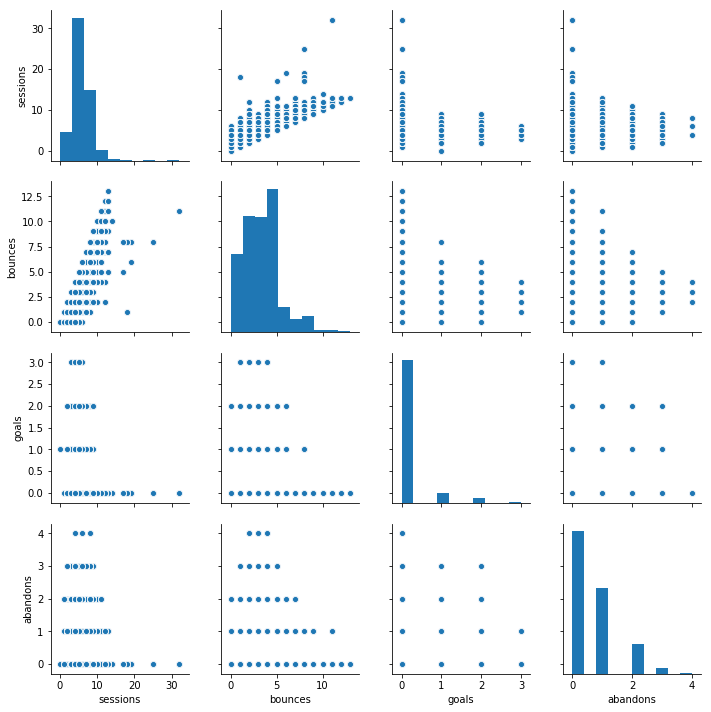

In [6]:
df_clustering = ga_class[['sessions', 'bounces', 'goals', 'abandons']]
sns.pairplot(df_clustering)

As you can see, the plot os not normalized and standardized, which is an assumption to K-Means algorithm and other clustering algorithms. So let's try to apply normalization and standardization:

In [7]:
cols = ['sessions', 'bounces', 'goals', 'abandons']
from sklearn.preprocessing import Normalizer
df_normalized = Normalizer().fit_transform(df_clustering[cols])

df_normalized = pd.DataFrame(df_normalized, columns=cols)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_normalized[cols])

df_scaled = pd.DataFrame(df_scaled, columns=cols)
df_scaled.head()

,sessions,bounces,goals,abandons
0,-1.680594,1.574687,-0.281153,-0.736606
1,-1.680594,1.574687,-0.281153,-0.736606
2,-1.680594,1.574687,-0.281153,-0.736606
3,-1.680594,1.574687,-0.281153,-0.736606
4,0.099151,0.371509,-0.281153,-0.736606


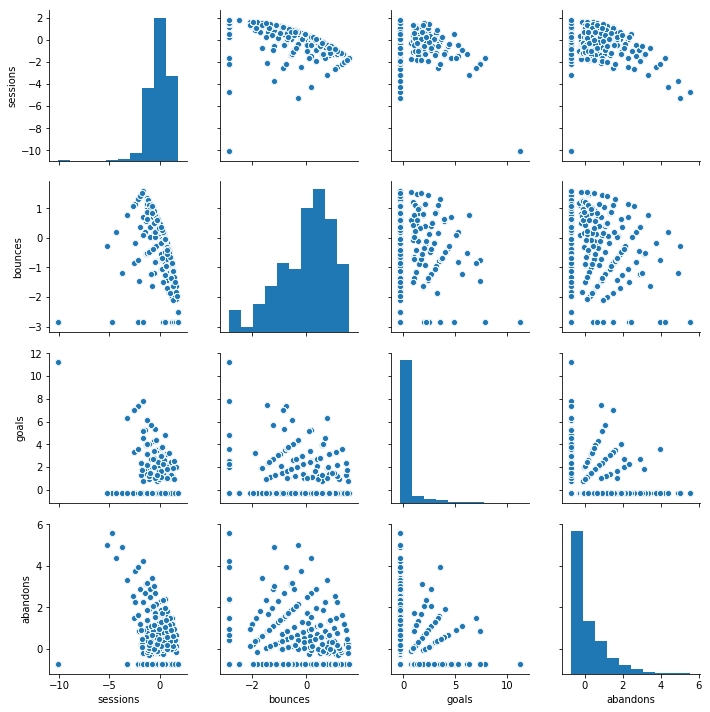

In [8]:
sns.pairplot(df_scaled)

As you can see, the distribution above has been improved

Let's proceed to the simplest clustering algorithm: K-Means

In [9]:
## Know how many clusters do we need to have using elbow criterion

from sklearn.cluster import KMeans
n_clusters=20
cost=[]
for i in range(1,n_clusters):
    kmean = KMeans(i)
    kmean.fit(df_scaled)
    cost.append(kmean.inertia_) 

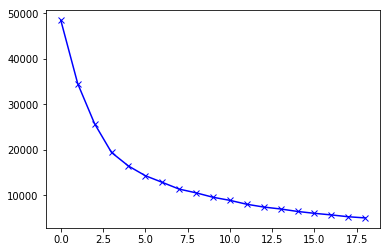

In [10]:
plt.plot(cost, 'bx-')

4 or 5 clusters is apparent, let's try the silhoutte score to make sure of the number of clusters

In [11]:
## Know how many clusters do we need to have using silhoutte score
from sklearn.metrics import silhouette_score

matrix = df_scaled.as_matrix()
for n_clusters in range (2, 10):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhoutte_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhoutte_avg)

C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


For n_clusters = 2 The average silhouette_score is : 0.3366642241153948
For n_clusters = 3 The average silhouette_score is : 0.3736353498682004
For n_clusters = 4 The average silhouette_score is : 0.4038431648801313
For n_clusters = 5 The average silhouette_score is : 0.34726035522861703
For n_clusters = 6 The average silhouette_score is : 0.3563287500256358
For n_clusters = 7 The average silhouette_score is : 0.3780746278044365
For n_clusters = 8 The average silhouette_score is : 0.38302959140744847
For n_clusters = 9 The average silhouette_score is : 0.3894715043317538


Now we are sure of using 4 clusters to get the behavior segments of a user

In [12]:
kmeans = KMeans(4, random_state=22)
kmeans.fit(df_scaled)
labels = kmeans.labels_
df2 = df_scaled.copy()
df2['cluster'] = labels

### 2-dimension plot

C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\207915\AppDat

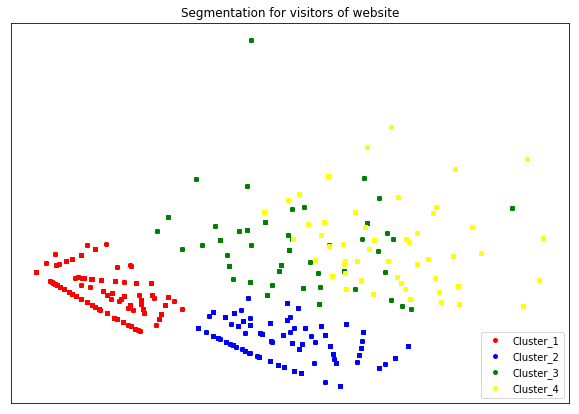

In [13]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(df2)
X_PCA = pca.transform(df2)
X_PCA.shape

x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5:'purple',}

names = {0: 'Cluster_1', 
         1: 'Cluster_2', 
         2: 'Cluster_3', 
         3: 'Cluster_4'}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(10, 7)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend(loc='lower right')
ax.set_title("Segmentation for visitors of website")
plt.savefig('ga_class_kmeans')

In [14]:
df = ga_class.copy()
df['cluster'] = labels
df.head()

,date,gender,device,sourceMedium,adContent,sessions,bounces,goals,abandons,cluster
0,201901020906,female,desktop,google / organic,(not set),3,3,0,0,0
1,201901020906,female,desktop,google / organic,(not set),3,3,0,0,0
2,201901020906,female,desktop,google / organic,(not set),3,3,0,0,0
3,201901020906,female,desktop,google / organic,(not set),3,3,0,0,0
4,201901021014,female,desktop,google / organic,(not set),5,3,0,0,0


We have now our final DataFrame for the prediction of the behavior segments of a user in website. But the data is not yet processed, let us do that then!

## Part 2A: Data Processing

**Process the data by cleaning it** <br>
I will extract features to get the date, source and medium columns. I will also use one-hot encoding for categorical variables device, source and medium.

In [15]:
df.head()

,date,gender,device,sourceMedium,adContent,sessions,bounces,goals,abandons,cluster
0,201901020906,female,desktop,google / organic,(not set),3,3,0,0,0
1,201901020906,female,desktop,google / organic,(not set),3,3,0,0,0
2,201901020906,female,desktop,google / organic,(not set),3,3,0,0,0
3,201901020906,female,desktop,google / organic,(not set),3,3,0,0,0
4,201901021014,female,desktop,google / organic,(not set),5,3,0,0,0


In [16]:
#df['date'] = df['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y%m%d%H%M'))
df['date'] = df['date'].apply(lambda x: datetime.strptime(str(x),'%Y%m%d%H%M'))

In [17]:
df['month'] = df['date'].apply(lambda x: (x.month))
df['day'] = df['date'].apply(lambda x: (x.day))
df['hour'] = df['date'].apply(lambda x: (x.hour))
df['minute'] = df['date'].apply(lambda x: (x.minute))

In [18]:
df.head(10)

,date,gender,device,sourceMedium,adContent,sessions,bounces,goals,abandons,cluster,month,day,hour,minute
0,2019-01-02 09:06:00,female,desktop,google / organic,(not set),3,3,0,0,0,1,2,9,6
1,2019-01-02 09:06:00,female,desktop,google / organic,(not set),3,3,0,0,0,1,2,9,6
2,2019-01-02 09:06:00,female,desktop,google / organic,(not set),3,3,0,0,0,1,2,9,6
3,2019-01-02 09:06:00,female,desktop,google / organic,(not set),3,3,0,0,0,1,2,9,6
4,2019-01-02 10:14:00,female,desktop,google / organic,(not set),5,3,0,0,0,1,2,10,14
5,2019-01-02 10:14:00,female,desktop,google / organic,(not set),5,3,0,0,0,1,2,10,14
6,2019-01-02 10:14:00,female,desktop,google / organic,(not set),5,3,0,0,0,1,2,10,14
7,2019-01-02 10:14:00,female,desktop,google / organic,(not set),5,3,0,0,0,1,2,10,14
8,2019-01-02 11:18:00,female,desktop,google / organic,(not set),3,2,0,2,3,1,2,11,18
9,2019-01-02 11:18:00,female,desktop,google / organic,(not set),3,2,0,2,3,1,2,11,18


In [19]:
df = df.drop(columns='date')

Compute the bounce rates, completion rates and abandon rates. Then, I will create a threshold that will label the row: bouncer, converter, abandoner and others

In [20]:
# get the source and medium features
df['source'] = df['sourceMedium'].str.split('/').str.get(0)
df['medium'] = df['sourceMedium'].str.split('/').str.get(1)

In [21]:
# investigate ad_content to get the features necessary
utm = df.adContent
utm_split = utm.str.split('-')
utm_subproduct = []
utm_promo = []
utm_description = []
utm_placement = []

for utm in utm_split:
    if utm[0][0:2] == 'FB':
        utm_subproduct.append(utm[1])
        utm_promo.append(utm[2])
        utm_description.append(utm[3]) 
        utm_placement.append('None')
    elif utm[0][0:2] == 'EM':
        utm_subproduct.append(utm[1])
        utm_promo.append(utm[2])
        utm_description.append('None') 
        utm_placement.append(utm[3])
    elif utm[-1][0] == 'x':
        utm_subproduct.append(utm[1])
        utm_promo.append(utm[2])
        utm_description.append('None') 
        utm_placement.append('None')
    else:
        utm_subproduct.append('None')
        utm_promo.append('None')
        utm_description.append(utm[0]) 
        utm_placement.append('None')
        
df['subproduct'] = utm_subproduct
df['promo'] = utm_promo
df['description'] = utm_description
df['em_placement'] = utm_placement
df.columns

Index(['gender', 'device', 'sourceMedium', 'adContent', 'sessions', 'bounces',
       'goals', 'abandons', 'cluster', 'month', 'day', 'hour', 'minute',
       'source', 'medium', 'subproduct', 'promo', 'description',
       'em_placement'],
      dtype='object')

In [22]:
df = df.drop(columns='adContent')
df = df.drop(columns='sourceMedium')

In [23]:
df.head(10)

,gender,device,sessions,bounces,goals,abandons,cluster,month,day,hour,minute,source,medium,subproduct,promo,description,em_placement
0,female,desktop,3,3,0,0,0,1,2,9,6,google,organic,None,None,(not set),None
1,female,desktop,3,3,0,0,0,1,2,9,6,google,organic,None,None,(not set),None
2,female,desktop,3,3,0,0,0,1,2,9,6,google,organic,None,None,(not set),None
3,female,desktop,3,3,0,0,0,1,2,9,6,google,organic,None,None,(not set),None
4,female,desktop,5,3,0,0,0,1,2,10,14,google,organic,None,None,(not set),None
5,female,desktop,5,3,0,0,0,1,2,10,14,google,organic,None,None,(not set),None
6,female,desktop,5,3,0,0,0,1,2,10,14,google,organic,None,None,(not set),None
7,female,desktop,5,3,0,0,0,1,2,10,14,google,organic,None,None,(not set),None
8,female,desktop,3,2,0,2,3,1,2,11,18,google,organic,None,None,(not set),None
9,female,desktop,3,2,0,2,3,1,2,11,18,google,organic,None,None,(not set),None


We have our dataset with the additional features, as we can see above. But we need to convert the string variables into numerical variables by using One-Hot encoding

In [24]:
# do a one-hot encoding for categorical variables for features generated from source_medium
df = pd.get_dummies(df, columns=['gender'])
df = pd.get_dummies(df, columns=['device'])
df = pd.get_dummies(df, columns=['source'])
df = pd.get_dummies(df, columns=['medium'])

In [25]:
# do a one-hot encoding for categorical variables
df = pd.get_dummies(df, columns=['subproduct'])
df = pd.get_dummies(df, columns=['promo'])
df = pd.get_dummies(df, columns=['description'])
df = pd.get_dummies(df, columns=['em_placement'])

In [26]:
pd.set_option("max_columns", 100)

In [27]:
print(df.columns)
df.head(10)

Index(['sessions', 'bounces', 'goals', 'abandons', 'cluster', 'month', 'day',
       'hour', 'minute', 'gender_female', 'gender_male', 'device_desktop',
       'device_mobile', 'device_tablet', 'source_google ', 'source_offline ',
       'medium_ cpc', 'medium_ organic', 'medium_ sms', 'subproduct_None',
       'subproduct_xaccallaccess', 'subproduct_xaccgeneral',
       'subproduct_xaccgold', 'promo_None', 'promo_debitraffle',
       'promo_draffle', 'promo_welcome', 'description_(not set)',
       'description_None', 'em_placement_None'],
      dtype='object')


,sessions,bounces,goals,abandons,cluster,month,day,hour,minute,gender_female,gender_male,device_desktop,device_mobile,device_tablet,source_google,source_offline,medium_ cpc,medium_ organic,medium_ sms,subproduct_None,subproduct_xaccallaccess,subproduct_xaccgeneral,subproduct_xaccgold,promo_None,promo_debitraffle,promo_draffle,promo_welcome,description_(not set),description_None,em_placement_None
0,3,3,0,0,0,1,2,9,6,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1
1,3,3,0,0,0,1,2,9,6,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1
2,3,3,0,0,0,1,2,9,6,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1
3,3,3,0,0,0,1,2,9,6,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1
4,5,3,0,0,0,1,2,10,14,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1
5,5,3,0,0,0,1,2,10,14,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1
6,5,3,0,0,0,1,2,10,14,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1
7,5,3,0,0,0,1,2,10,14,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1
8,3,2,0,2,3,1,2,11,18,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1
9,3,2,0,2,3,1,2,11,18,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1


Now we have our true final dataset. Let's do the supervised machine learning part

## Part 2B: Supervised Machine Learning

Check if there are undersampled labels from clustering:

In [47]:
df.cluster.value_counts()

0    5432
1    4288
3    1828
2     580
Name: cluster, dtype: int64

As you can see, they are distributed well, so we will proceed with creating train and test datasets for supervised learning.

In [51]:
from sklearn.model_selection import train_test_split

# repeated_cols are variables used for clustering, which is already redundant for the labels
repeated_cols = ['sessions', 'bounces', 'goals', 'abandons']
X = df.drop(['cluster'], axis = 1)
X = X.drop(['sessions', 'bounces', 'goals', 'abandons'], axis = 1)
y = df['cluster']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=60, stratify=y)

### Logistic Regression

In [54]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model_logreg = LogisticRegression()
model_logreg.fit(X_train, y_train)
y_pred = model_logreg.predict(X_test)
accuracy_score(y_test, y_pred)

C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.4637262984336356

In [55]:
from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=model_logreg, X=X_train, y=y_train, cv=5) 

print(all_accuracies)
print(all_accuracies.mean())

C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Use

[0.45983522 0.46058733 0.44948454 0.46597938 0.46312532]
0.45980235747972864


In [56]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model_logreg, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0116 ± 0.0113,hour
0.0026 ± 0.0103,day
0.0023 ± 0.0049,promo_None
0.0017 ± 0.0048,subproduct_None
0.0015 ± 0.0041,device_mobile
0.0015 ± 0.0026,medium_ organic
0.0014 ± 0.0013,promo_debitraffle
0.0013 ± 0.0030,source_google
0.0013 ± 0.0039,subproduct_xaccgold
0.0012 ± 0.0046,description_(not set)


#### Try this on another time

In [57]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_curve, auc
from imblearn.pipeline import Pipeline

steps = [('scaler', StandardScaler()), 
         ('logreg', LogisticRegression(solver='liblinear', random_state = 60))]
pipeline = Pipeline(steps)

C_vals = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,16.5,17,17.5,18]
penalties = ['l1','l2']
cv = StratifiedShuffleSplit(n_splits = 10, test_size = .25, random_state = 60)
param = {'logreg__penalty': penalties, 'logreg__C': C_vals}

grid = GridSearchCV(estimator=pipeline, 
                           param_grid = param,
                           scoring = 'accuracy',
                            n_jobs =-1,
                           cv = cv
                          )
grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [33]:
print (grid.best_score_)
print (grid.best_params_)
print(grid.best_estimator_)

0.9995465787304204
{'logreg__C': 8, 'logreg__penalty': 'l1'}
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logreg',
                 LogisticRegression(C=8, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=60,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [34]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = grid.predict(X_test)
y_score = grid.decision_function(X_test)

FPR_log, TPR_log, _ = roc_curve(y_test, y_score)
ROC_AUC_log = auc(FPR_log, TPR_log)

print(accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))
print (ROC_AUC_log)

ValueError: multiclass format is not supported

### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

steps = [('scaler', StandardScaler()), 
         ('svc', SVC(kernel = 'sigmoid', probability=True))]
pipeline = Pipeline(steps)

Cs = [0.001, 0.01, 0.1, 1,1.5,2,2.5,3,4,5, 10] ## penalty parameter C for the error term. 
gammas = [0.0001,0.001, 0.01, 0.1, 1]
param = {'svc__C': Cs, 'svc__gamma' : gammas}
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=60)

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid = param, cv=cv)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

In [ ]:
svc_pred = grid_search.predict(X_test)
svc_score = grid_search.decision_function(X_test)

FPR_svc, TPR_svc, _ = roc_curve(y_test, svc_score)
ROC_AUC_svc = auc(FPR_svc, TPR_svc)

print(accuracy_score(svc_pred, y_test))
print(confusion_matrix(y_test,svc_pred))  
print(classification_report(y_test,svc_pred))
print (ROC_AUC_svc)

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

steps = [('scaler', StandardScaler()), 
         ('tree', DecisionTreeClassifier(random_state=60))]
pipeline = Pipeline(steps)

max_depth = range(1,30)
max_feature = [21,22,23,24,25,26,28,29,30,'auto']
criterion=["entropy", "gini"]
param = {'tree__max_depth':max_depth, 
         'tree__max_features':max_feature, 
         'tree__criterion': criterion}

grid_tree = GridSearchCV(estimator = pipeline, 
                                param_grid = param, 
                                 verbose=False, 
                                 cv=StratifiedKFold(n_splits=20, random_state=60),
                                n_jobs = -1)
grid_tree.fit(X_train, y_train)

In [ ]:
print( grid_tree.best_params_)
print (grid_tree.best_score_)
print (grid_tree.best_estimator_)

In [ ]:
dec_pred = grid_tree.predict(X_test)
dec_score = grid_tree.predict_proba(X_test)[:, 1]

FPR_dec, TPR_dec, _ = roc_curve(y_test, dec_score)
ROC_AUC_dec = auc(FPR_dec, TPR_dec)

print(accuracy_score(dec_pred, y_test))
print(confusion_matrix(y_test,dec_pred))  
print(classification_report(y_test,dec_pred))
print (ROC_AUC_dec)

### Random Forest

In [61]:
y_test.value_counts()

0    1086
1     858
3     366
2     116
Name: cluster, dtype: int64

In [58]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

model_randomforest = RandomForestClassifier()
model_randomforest.fit(X_train, y_train)
y_pred = model_randomforest.predict(X_test)
accuracy_score(y_test, y_pred)

C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1.0

In [62]:
from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=model_randomforest, X=X_train, y=y_train, cv=5)
print(all_accuracies)
print(all_accuracies.mean())

[0.99948507 1.         1.         0.99845361 0.99845281]
0.99927829718318


In [63]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model_randomforest, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.4432 ± 0.0084,minute
0.4406 ± 0.0076,day
0.4148 ± 0.0207,hour
0.3175 ± 0.0086,month
0.0964 ± 0.0036,device_desktop
0.0141 ± 0.0033,gender_female
0.0057 ± 0.0003,subproduct_xaccgold
0.0050 ± 0.0023,medium_ cpc
0.0043 ± 0.0030,medium_ organic
0.0038 ± 0.0003,gender_male


In [ ]:
from sklearn.ensemble import RandomForestClassifier

steps = [('scaler', StandardScaler()), 
         ('rf', RandomForestClassifier(max_features='auto', random_state=60))]
pipeline = Pipeline(steps)

n_estimators = [140,145,150,155,160];
max_depth = range(1,10);
criterions = ['gini', 'entropy'];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=60)
parameters = {'rf__n_estimators':n_estimators,
              'rf__max_depth':max_depth,
              'rf__criterion': criterions}

grid_rf = GridSearchCV(estimator=pipeline,
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
grid_rf.fit(X_train,y_train) 

In [ ]:
print (grid_rf.best_score_)
print (grid_rf.best_params_)
print (grid_rf.best_estimator_)

In [ ]:
rf_pred = grid_rf.predict(X_test)
rf_score = grid_rf.predict_proba(X_test)[:, 1]

FPR, TPR, _ = roc_curve(y_test, rf_score)
ROC_AUC = auc(FPR, TPR)

print(accuracy_score(rf_pred, y_test))
print(confusion_matrix(y_test,rf_pred))  
print(classification_report(y_test,rf_pred))
print (ROC_AUC)

### XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

steps = [('scaler', StandardScaler()), 
         ('xgb', XGBClassifier())]
pipeline = Pipeline(steps)


cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=60)

params = {'xgb__min_child_weight': [1, 5, 10],
        'xgb__n_estimators': [4, 100, 800, 1000],
        'xgb__learning_rate': [1, 0.5, 0.1, 0.05, 0.01],
        'xgb__gamma': [0.5, 1, 1.5, 2, 5],
        'xgb__subsample': [0.5, 0.75, 0.95, 1.0],
        'xgb__colsample_bytree': [0.6, 0.8, 1.0],
        'xgb__max_depth': range(1,10)}

random_xgb = RandomizedSearchCV(pipeline, param_distributions=params, scoring='roc_auc', n_jobs=-1,
                                   cv=cv, verbose=3, random_state=60)


random_xgb.fit(X_train,y_train) 

In [ ]:
print (random_xgb.best_score_)
print (random_xgb.best_params_)
print (random_xgb.best_estimator_)

In [ ]:
xgb_pred = random_xgb.predict(X_test)
xgb_score = random_xgb.predict_proba(X_test)[:, 1]

FPR, TPR, _ = roc_curve(y_test, xgb_score)
ROC_AUC = auc(FPR, TPR)

print(accuracy_score(xgb_pred, y_test))
print(confusion_matrix(y_test,xgb_pred))  
print(classification_report(y_test,xgb_pred))
print (ROC_AUC)

## Proceed to Data Visualization

C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


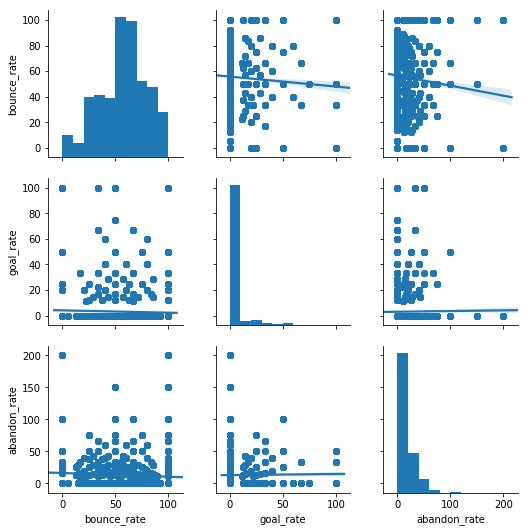

In [18]:
cols = ['bounce_rate','goal_rate', 'abandon_rate']
sns.pairplot(ga_class[cols], kind='reg')
plt.show()

## Proceed to EDA and Statistics

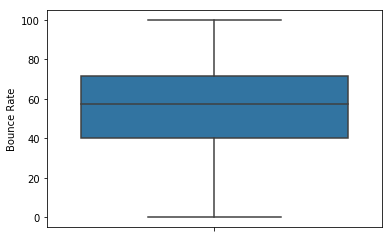

In [19]:
# Create box plot with Seaborn's default settings
_ = sns.boxplot(y='bounce_rate', data=ga_class)
# Label the axes
_ = plt.ylabel('Bounce Rate')
# Show the plot
plt.show()

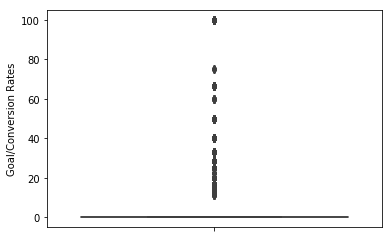

In [20]:
# Create box plot with Seaborn's default settings
_ = sns.boxplot(y='goal_rate', data=ga_class)
# Label the axes
_ = plt.ylabel('Goal/Conversion Rates')
# Show the plot
plt.show()

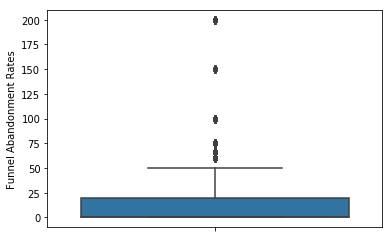

In [21]:
# Create box plot with Seaborn's default settings
_ = sns.boxplot(y='abandon_rate', data=ga_class)
# Label the axes
_ = plt.ylabel('Funnel Abandonment Rates')
# Show the plot
plt.show()

In [22]:
# where data is the column that includes the value we are interested
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

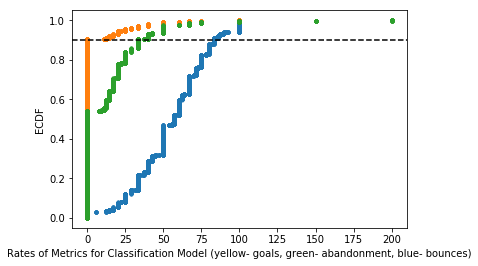

In [35]:
bounces = np.array(ga_class['bounce_rate'])
goals = np.array(ga_class['goal_rate'])
abandons = np.array(ga_class['abandon_rate'])

# Compute ECDF for versicolor data: x_vers, y_vers
x, y = ecdf(bounces)
x2, y2 = ecdf(goals)
x3, y3 = ecdf(abandons)
mean1 =  np.mean(bounces)
median2 =  np.median(goals)
median3 =  np.median(abandons)

# Generate plot
plt.plot(x, y, marker='.', linestyle='none')
plt.plot(x2, y2, marker='.', linestyle='none')
plt.plot(x3, y3, marker='.', linestyle='none')

# Label the axes
plt.xlabel('Rates of Metrics for Classification Model (yellow- goals, green- abandonment, blue- bounces)')
plt.ylabel('ECDF')

# Display the plot
plt.axhline(0.9, color='black', linestyle='--')
plt.show()

In [24]:
display(ga_class['bounce_rate'].describe())
display(ga_class['goal_rate'].describe())
display(ga_class['abandon_rate'].describe())

count    12128.000000
mean        55.464291
std         23.197239
min          0.000000
25%         40.000000
50%         57.140000
75%         71.430000
max        100.000000
Name: bounce_rate, dtype: float64

count    12128.000000
mean         3.065531
std         11.276428
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        100.000000
Name: goal_rate, dtype: float64

count    12128.000000
mean        12.940953
std         19.900828
min          0.000000
25%          0.000000
50%          0.000000
75%         20.000000
max        200.000000
Name: abandon_rate, dtype: float64

### Bootstrapping the metrics - goals, bounces, and abandons

In [25]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


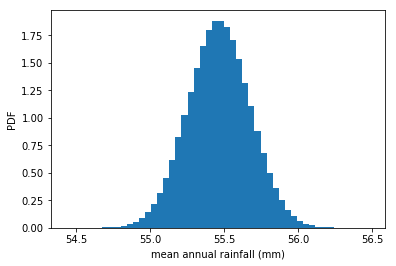

In [26]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates1 = draw_bs_reps(bounces, np.mean, size=1000000)

# Make a histogram of the results
_ = plt.hist(bs_replicates1, bins=50,  normed=True)
_ = plt.xlabel('mean annual rainfall (mm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

In [27]:
#### Add this code in the bootstrap replicates to do a bootstrap testing
p = np.sum(bs_replicates1 <= np.mean(bounces)) / 1000000

# Print the p-value
print('p = ', p)

p =  0.500363


In [28]:
# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates1, [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

95% confidence interval = [55.05199454 55.87762638] games


C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


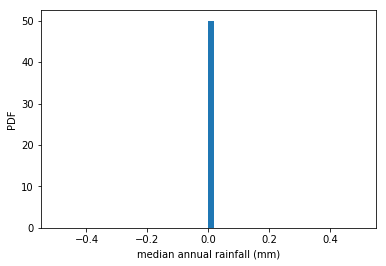

In [29]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates2 = draw_bs_reps(goals, np.median, size=1000000)

# Make a histogram of the results
_ = plt.hist(bs_replicates2, bins=50,  normed=True)
_ = plt.xlabel('median annual rainfall (mm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

In [30]:
#### Add this code in the bootstrap replicates to do a bootstrap testing
p = np.sum(bs_replicates2 <= np.median(goals)) / 1000000

# Print the p-value
print('p = ', p)

p =  1.0


In [31]:
# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates2, [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

95% confidence interval = [0. 0.] games


C:\Users\207915\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


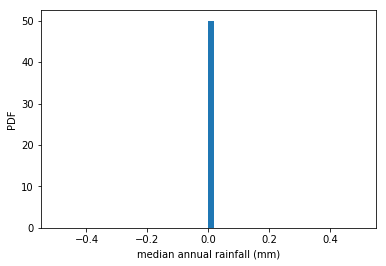

In [32]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates3 = draw_bs_reps(abandons, np.median, size=1000000)

# Make a histogram of the results
_ = plt.hist(bs_replicates3, bins=50,  normed=True)
_ = plt.xlabel('median annual rainfall (mm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

In [33]:
#### Add this code in the bootstrap replicates to do a bootstrap testing
p = np.sum(bs_replicates3 <= np.median(goals)) / 1000000

# Print the p-value
print('p = ', p)

p =  1.0


In [34]:
# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates3, [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

95% confidence interval = [0. 0.] games


## Labelling the dataset

## Proceed to Data Modelling

In [ ]:
# preparing the predictor and dependent variables
features = ga_class.columns.tolist()
features.remove('goal1')
features.remove('bounces')
X, y = ga_class.loc[:, features], ga_class.loc[:,'goal1']
print(X.shape)
print(y.shape)

In [ ]:
# Split the data into training and testing data set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [ ]:
#Random Forest Classifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split

pl_random_forest = Pipeline(steps=[('random_forest', RandomForestClassifier())])
training_score = cross_val_score(pl_random_forest, X_train, y_train, cv=5, scoring='accuracy')
test_score = cross_val_score(pl_random_forest, X_test, y_test, cv=5, scoring='accuracy')
print('Training Accuracy for RandomForest is : ', training_score.mean())
print('Test Accuracy for RandomForest is : ', test_score.mean())